In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
print(tf.executing_eagerly())
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
import json
from PIL import Image
import os
import random

2024-04-27 10:07:31.592651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 10:07:31.592747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 10:07:31.748139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


True


# Arthropod Taxonomy Object Detection

We won't be using the entire dataset. We will use around 500-700 images from each
* Araneae(Spider)
* Coleoptera(Beetles)
* Diptera(True Flies)
* Hemiptera(True bugs)<br>
This choice is purely arbitrary, and made to lower the time taken for training. We will essentially build a classification model to differentiate between the four classes and a regression model to determine the position of the box.

## Loading the Dataset

In [2]:
"""Utility function that returns image file path after extracting from json data"""
def image_path(json_data, index):
    if index < 1000:
        return filepaths[0] + "/" + json_data[index]['asset']['name']
    elif index < 2000:
        return filepaths[1] + "/" + json_data[index]['asset']['name']
    elif index < 3000:
        return filepaths[2] + "/" + json_data[index]['asset']['name']
    return filepaths[3] + "/" + json_data[index]['asset']['name']

def box_data(json_data, index):
    return [json_data[index]['regions'][0]['boundingBox']['top'],json_data[index]['regions'][0]['boundingBox']['left'],
           json_data[index]['regions'][0]['boundingBox']['width'],json_data[index]['regions'][0]['boundingBox']['height']]

In [3]:
image_files = []
json_data = []
# Define filepath for each class in a list
path = "/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr"
filepaths = [f"{path}/Araneae", f"{path}/Coleoptera", f"{path}/Diptera", f"{path}/Hemiptera"]
for folder in filepaths:
    count =1000
    for dirname, _, filenames in os.walk(f"{folder}/annotations"):
        for filename in filenames:
            if count == 0: break
            file = os.path.join(dirname, filename)
            if file[-4:] == "json":
                image_files.append(file)
                with open(file, 'r') as json_file:
                    check = json.load(json_file)
                json_data.append(check)
                count -= 1
len(json_data)

4000

In [4]:
json_data[0]

{'asset': {'format': 'jpg',
  'id': '92c3b5afa8bb650f08e901b303129315',
  'name': 'd828dafe2fe4.jpg',
  'path': 'file:F:/ArTaxOr/Araneae/d828dafe2fe4.jpg',
  'size': {'width': 1799, 'height': 1349},
  'state': 2,
  'type': 1},
 'regions': [{'id': 'IbPy8VHgN',
   'type': 'RECTANGLE',
   'tags': ['Araneae'],
   'boundingBox': {'height': 820.5124521072796,
    'width': 1407.4073275862067,
    'left': 181.1156496946839,
    'top': 94.32662835249042},
   'points': [{'x': 181.1156496946839, 'y': 94.32662835249042},
    {'x': 1588.5229772808907, 'y': 94.32662835249042},
    {'x': 1588.5229772808907, 'y': 914.83908045977},
    {'x': 181.1156496946839, 'y': 914.83908045977}]}],
 'version': '2.1.0'}

/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae/a0009368c551.jpg


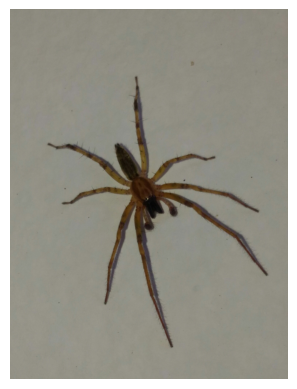

In [5]:
"""Sample Image"""
sample_img_path = image_path(json_data, 500)
print(sample_img_path)
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [6]:
#sample_annotation_path = sample_img_path[0:-4] + '.txt'
#with open(sample_annotation_path) as f:
#    print(f.readlines())
"""Example box coordinates"""
json_data[103]['regions'][0]['boundingBox']

{'height': 238.3448275862069,
 'width': 188.32183908045977,
 'left': 980.5977011494252,
 'top': 679.7241379310344}

In [7]:
"""Function to extract all image files from json data and split them into train and test"""
def list_files(json_data, split_percentage = [70,20]):
    spider = []
    beetle = []
    butterfly = []
    dragonfly = []
    for i in range(1000):
        spider.append(json_data[i])
        beetle.append(json_data[i+1])
        butterfly.append(json_data[i+2])
        dragonfly.append(json_data[i+3])
    random.shuffle(spider)
    random.shuffle(beetle)
    random.shuffle(butterfly)
    random.shuffle(dragonfly)
    split_train = split_percentage[0] * 10
    split_valid = split_train + (split_percentage[1] * 10)
    train = spider[:split_train] + beetle[:split_train] + butterfly[:split_train] + dragonfly[:split_train]
    valid = spider[split_train:split_valid] + beetle[split_train:split_valid] + butterfly[split_train:split_valid] + dragonfly[split_train:split_valid]
    test = spider[split_valid:] + beetle[split_valid:] + butterfly[split_valid:] + dragonfly[split_valid:]
    return train, valid, test

training_files, validation_files, test_files = list_files(json_data)

print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

2800 training files
800 validation files
400 test files


In [8]:
input_size = 244

"""Function to resize the image"""
def format_image(img, box):
    height, width = img.shape
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x) / r), int((y)  / r), int(w / r), int(h / r)]

    return new_image, new_box

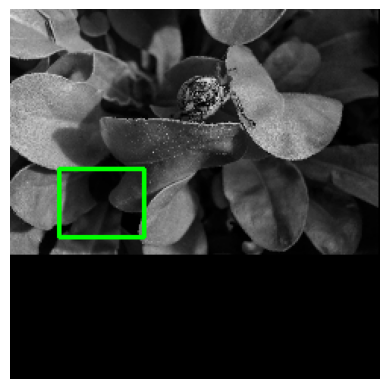

In [9]:
"""Testing the resizing funciton"""
temp_img = cv.imread(image_path(json_data, 1000), cv.IMREAD_GRAYSCALE)
#temp_box = [0.38183279742765275, 0.6171428571428571, 0.43569131832797425, 0.6285714285714286]
temp_box = box_data(json_data, 1000)
temp_img_formated, box = format_image(temp_img, temp_box)
temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 255, 0), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

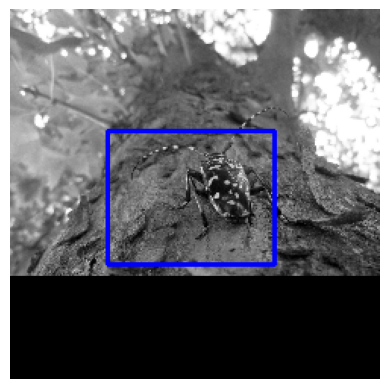

In [10]:
#temp_img = cv.imread(f"{filepath}/149.jpg", cv.IMREAD_GRAYSCALE)
#temp_box = [0.5171875, 0.5911214953271028, 0.621875, 0.6495327102803738]
temp_img = cv.imread(image_path(json_data, 1394), cv.IMREAD_GRAYSCALE)
temp_box = box_data(json_data, 1394)
temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

cv.rectangle(temp_color_img, box, (0, 0, 255), 2)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

In [11]:
"""Loads the dataset in tensors"""
def data_load(json_data_new):
    X = []
    Y = []
    count = 0
    for i in range(len(json_data_new)):
        img = cv.imread(image_path(json_data_new, i), cv.IMREAD_GRAYSCALE)
        if(type(img) == type(None)):
            count += 1
            continue
        box = box_data(json_data_new, i)
        img, box = format_image(img, box)
        img = img.astype(float) / 255
        box = np.asarray(box, dtype = float) / input_size
        label = np.append(box, i // 500)
        X.append(img)
        Y.append(label)
    X = np.array(X)
    X = np.expand_dims(X, axis=3)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = np.array(Y)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    result = tf.data.Dataset.from_tensor_slices((X, Y))
    return result

In [29]:
%%capture
raw_train_ds = data_load(training_files)
raw_validation_ds = data_load(validation_files)
raw_test_ds = data_load(test_files)

[ WARN:0@998.117] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae/34f2f8c20c6c.jpg'): can't open/read file: check file path/integrity
[ WARN:0@998.543] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Coleoptera/be20a9ea67da.jpg'): can't open/read file: check file path/integrity
[ WARN:0@998.543] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Coleoptera/d0cb69894fda.jpg'): can't open/read file: check file path/integrity
[ WARN:0@998.544] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Coleoptera/361584f9b107.jpg'): can't open/read file: check file path/integrity
[ WARN:0@998.544] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Coleopt

In [13]:
print(f"Train Data Size: {len(raw_train_ds)}")
print(f"Validation Data Size: {len(raw_validation_ds)}")
print(f"Test Data Size: {len(raw_test_ds)}")

Train Data Size: 1001
Validation Data Size: 800
Test Data Size: 400


In [14]:
CLASSES = 4

"""Gets one hot encoding of the classes"""
def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [15]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = tune_training_ds(raw_train_ds)

In [16]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

validation_ds = tune_validation_ds(raw_validation_ds)

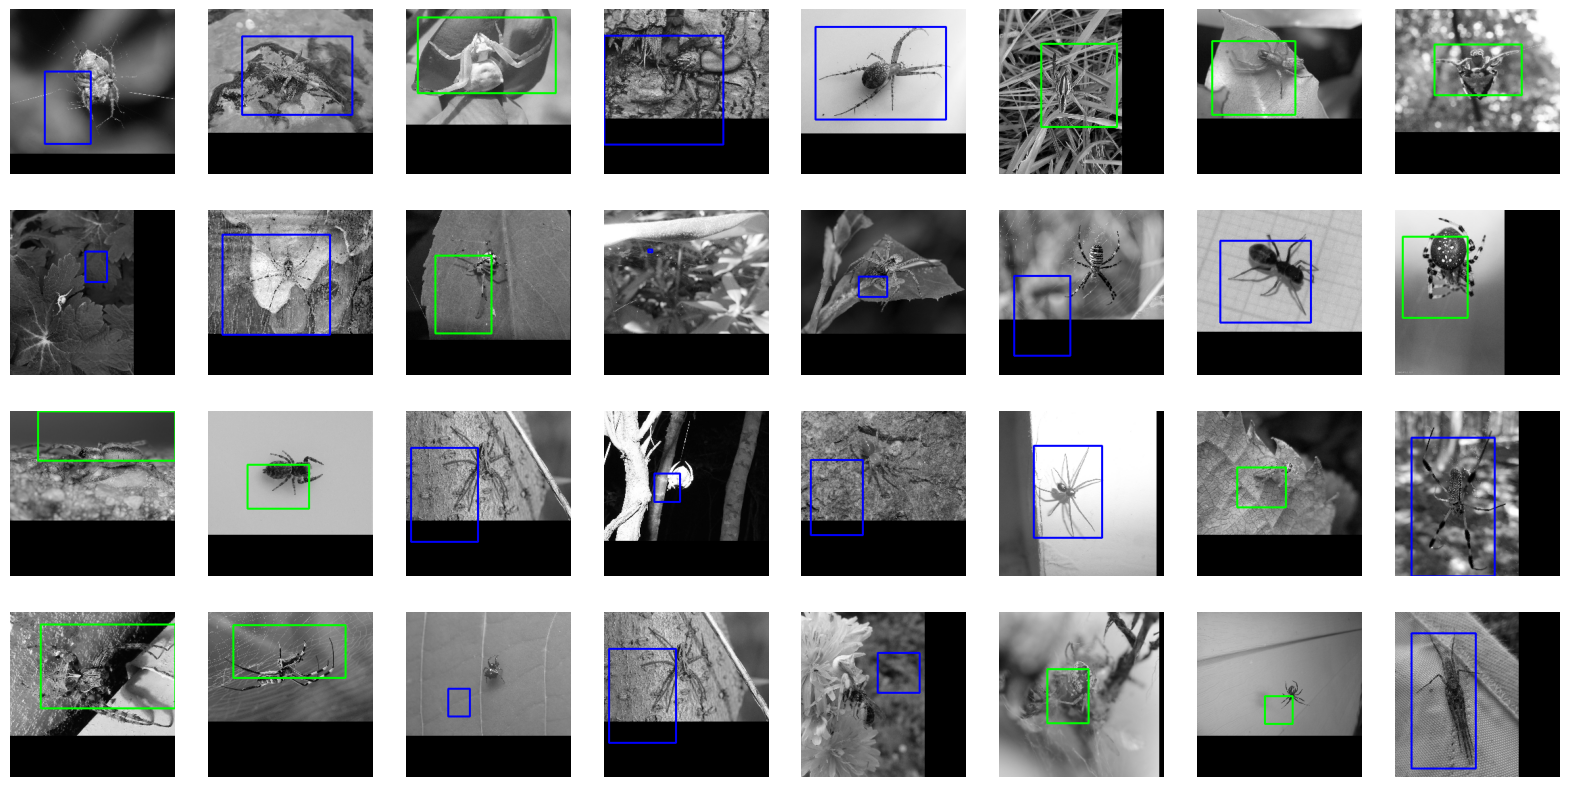

In [17]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

## Building a CNN

In [18]:
DROPOUT_FACTOR = 0.5

def build_feature_extractor(inputs):

    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
    x = tf.keras.layers.AveragePooling2D(2,2)(x)

    return x

def build_model_adaptor(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def build_classifier_head(inputs):
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(inputs)

def build_regressor_head(inputs):
    return tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)

def build_model(inputs):
    
    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })
    
    return model

In [19]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 244, 244, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 242, 242, 16)         160       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 121, 121, 16)         0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 119, 119, 32)         4640      ['average_pooling2d[0][0]'

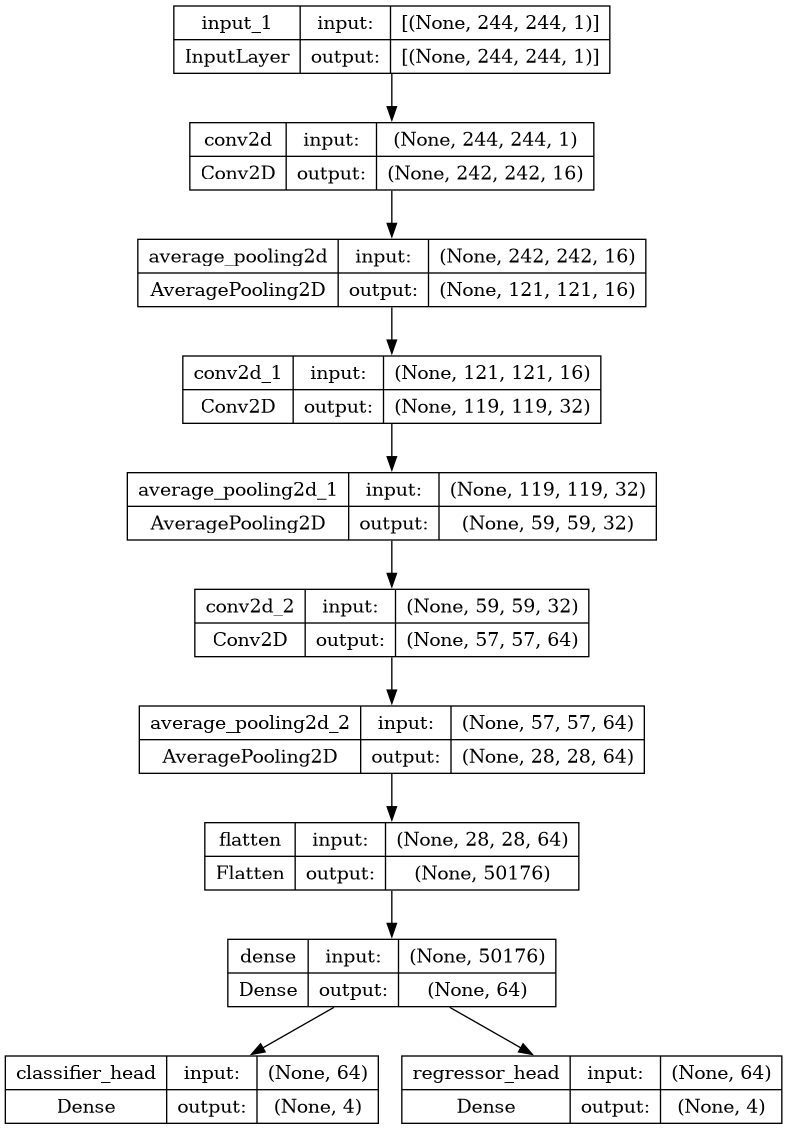

In [20]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [22]:
EPOCHS = 11

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1, 
                    epochs=EPOCHS)

Epoch 1/11
87/87 [==============================] - 45s 513ms/step - loss: 0.5613 - classifier_head_loss: 0.5314 - regressor_head_loss: 0.0299 - classifier_head_accuracy: 0.7180 - regressor_head_mse: 0.0299 - val_loss: 0.6505 - val_classifier_head_loss: 0.6115 - val_regressor_head_loss: 0.0390 - val_classifier_head_accuracy: 0.6950 - val_regressor_head_mse: 0.0390
Epoch 2/11
87/87 [==============================] - 44s 509ms/step - loss: 0.5003 - classifier_head_loss: 0.4772 - regressor_head_loss: 0.0231 - classifier_head_accuracy: 0.7381 - regressor_head_mse: 0.0231 - val_loss: 1.2974 - val_classifier_head_loss: 1.2573 - val_regressor_head_loss: 0.0401 - val_classifier_head_accuracy: 0.3650 - val_regressor_head_mse: 0.0401
Epoch 3/11
87/87 [==============================] - 44s 507ms/step - loss: 0.4407 - classifier_head_loss: 0.4257 - regressor_head_loss: 0.0150 - classifier_head_accuracy: 0.7708 - regressor_head_mse: 0.0150 - val_loss: 1.2181 - val_classifier_head_loss: 1.1838 - val

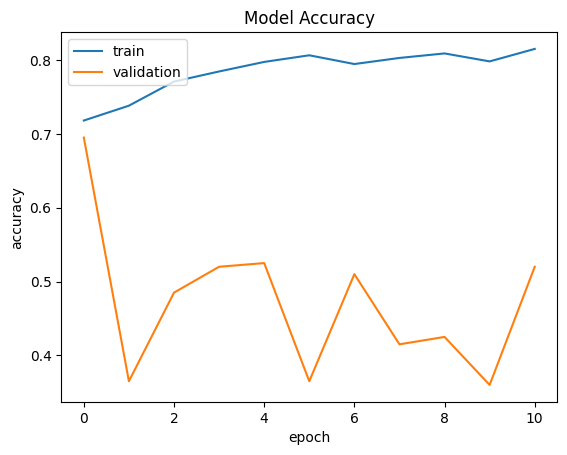

In [23]:
plt.plot(history.history['classifier_head_accuracy'])
plt.plot(history.history['val_classifier_head_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

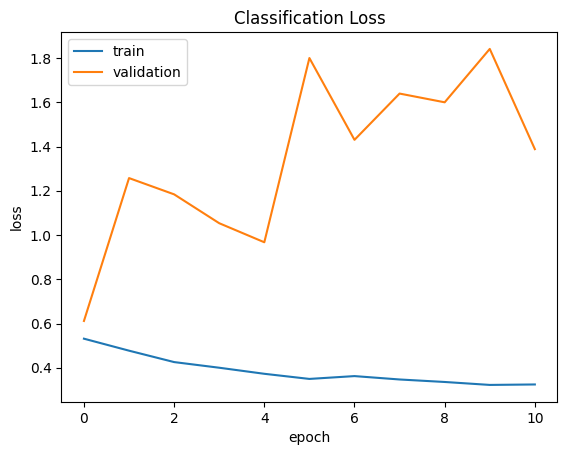

In [24]:
plt.plot(history.history['classifier_head_loss'])
plt.plot(history.history['val_classifier_head_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

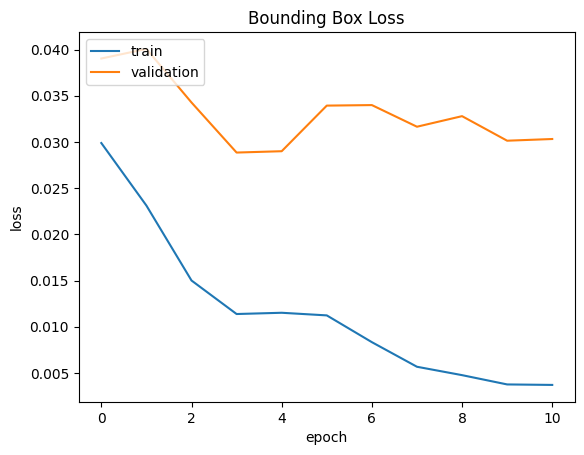

In [25]:
plt.plot(history.history['regressor_head_loss'])
plt.plot(history.history['val_regressor_head_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
def intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
    boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [27]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

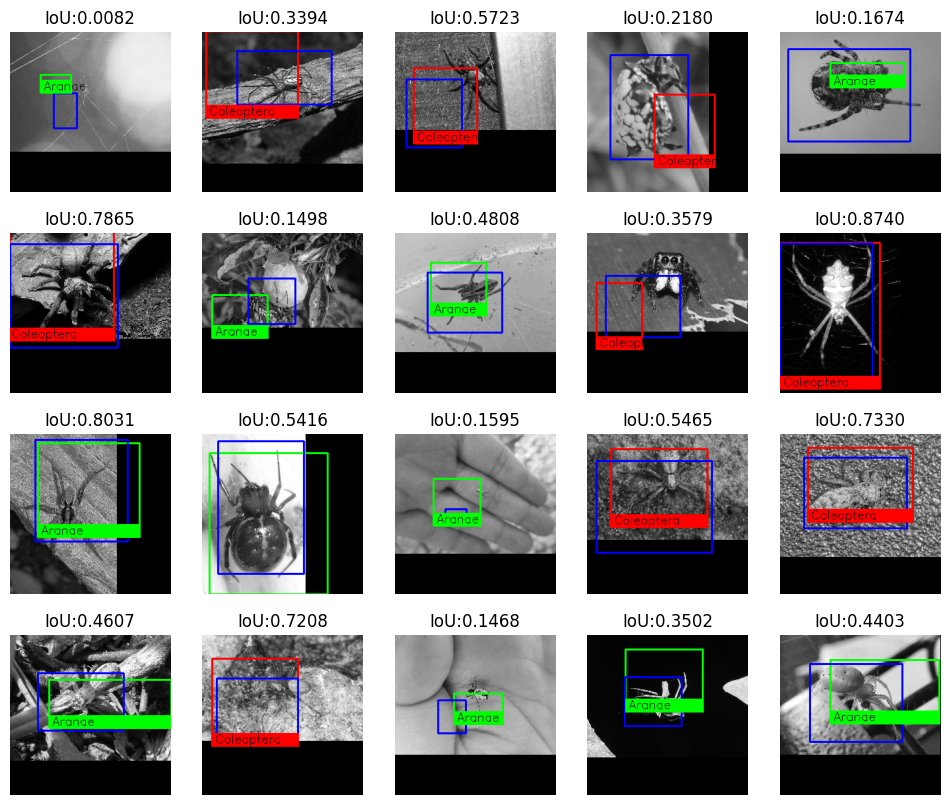

In [28]:
plt.figure(figsize=(12, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 5, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[1] > 0.5 and actual_label[1] > 0) or (predicted_label[2] > 0.5 and actual_label[2] > 0) or (predicted_label[3] > 0.5 and actual_label[3] > 0):
        color = (0, 255, 0)

    img_label = "Aranae"
    if predicted_label[1] > 0.5:
        img_label = "Coleoptera"
    elif predicted_label[2] > 0.5:
        img_label = "Diptera"
    elif predicted_label[3] > 0.5:
        img_label = "Hemiptera"

    predicted_box_n = predicted_box.numpy()
    cv.rectangle(image_color, predicted_box_n, color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
    cv.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
    cv.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")